# Assignment 2

In [75]:
# Spotify parsing
import billboard
from spotipy.oauth2 import SpotifyClientCredentials
# Pandas work
from collections import defaultdict
from sklearn import linear_model, svm, model_selection, metrics, naive_bayes, neighbors, ensemble
import scipy
import random
import csv
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as sk
import pandas as pd

In [2]:
# https://stackoverflow.com/questions/45927801/trouble-setting-up-credentials-in-spotipy
# https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks <- dataset
import configparser

import spotipy
import spotipy.oauth2 as oauth2

config = configparser.ConfigParser()
config.read('config.cfg')
client_id = config.get('SPOTIFY', 'CLIENT_ID')
client_secret = config.get('SPOTIFY', 'CLIENT_SECRET')


auth = oauth2.SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)

token = auth.get_access_token()
spotify = spotipy.Spotify(auth=token)

<ipython-input-2-bf9dc4d44692>:19: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  token = auth.get_access_token()


## Data Parsing and Splitting

In [3]:
cols = []
data = []

with open('combined_spotify_data.csv', encoding='utf-8') as file:
    read_data = csv.reader(file)
    for row in read_data:
        if row[0] == '':
            cols = row[1:-1]
        elif int(row[4]) < 1940:
            continue
        else:
            row_data = {}
            
            curr_col = 1
            for col in cols:
                row_data[col] = row[curr_col]
                curr_col += 1
            
            data.append(row_data)

In [4]:
data_shuffled = data.copy()
random.shuffle(data_shuffled)

In [5]:
len(data_shuffled)

155978

In [6]:
training = data_shuffled[:116980]
validation = data_shuffled[116980:]

In [7]:
validation

[{'id': '2Faph853koDwlFV7TyQHKy',
  'name': 'Nice To Be Here',
  'artists': "['The Moody Blues']",
  'year': '1971',
  'release_date': '1971-07-23',
  'duration_ms': '263880',
  'valence': '0.527',
  'acousticness': '0.5670000000000001',
  'danceability': '0.526',
  'energy': '0.35',
  'explicit': '0',
  'instrumentalness': '0.847',
  'key': '0',
  'liveness': '0.222',
  'loudness': '-15.383',
  'mode': '1',
  'popularity': '24',
  'speechiness': '0.0294',
  'tempo': '107.906',
  'on_billboard': '0'},
 {'id': '1gOY7s8paedQloNFbomy9e',
  'name': 'O Baboo Kaise Dil Karoon Qaboo',
  'artists': "['Lata Mangeshkar', 'Amirbai Karnataki']",
  'year': '1951',
  'release_date': '1951-01-01',
  'duration_ms': '190827',
  'valence': '0.965',
  'acousticness': '0.845',
  'danceability': '0.5539999999999999',
  'energy': '0.409',
  'explicit': '0',
  'instrumentalness': '2.28e-06',
  'key': '1',
  'liveness': '0.0281',
  'loudness': '-14.822000000000001',
  'mode': '1',
  'popularity': '0',
  'spee

## Baseline Creation

In [8]:
# First Baseline: Popularity Threshold (Median)
popularities = [int(d['popularity']) for d in training]

cut_off = np.median(popularities)

In [9]:
actual_on_billboard = [bool(int(d['on_billboard'])) for d in validation]
pred_on_billboard = []

for d in validation:
    pred_on_billboard.append(int(d['popularity']) > cut_off)
    

In [10]:
# Method to calculate the BER given predictions and y values
def calcBER(predictions, y):
    # True positives, false positives, etc.
    TP_ = np.logical_and(predictions, y)
    FP_ = np.logical_and(predictions, np.logical_not(y))
    TN_ = np.logical_and(np.logical_not(predictions), np.logical_not(y))
    FN_ = np.logical_and(np.logical_not(predictions), y)

    TP = sum(TP_)
    FP = sum(FP_)
    TN = sum(TN_)
    FN = sum(FN_)

    # BER
    BER = 1 - 0.5 * (TP / (TP + FN) + TN / (TN + FP))

    print('BER: {}'.format(BER))
    
    # Accuracy
    accuracy = (TP + TN) / (TP + FP + TN + FN)
    
    print('Accuracy: {}'.format(accuracy))

In [11]:
calcBER(pred_on_billboard, actual_on_billboard)

BER: 0.3012381583514194
Accuracy: 0.573773014000718


In [12]:
# Second Baseline: 'Pop' Music Traits Threshold (Median)
energy_indices = [float(d['energy']) for d in training]
tempos = [float(d['tempo']) for d in training]
danceability_indices = [float(d['danceability']) for d in training]
valence_indices = [float(d['valence']) for d in training]

energy_cut_off = np.median(energy_indices)
tempo_cut_off = np.median(tempos)
dance_cut_off = np.median(danceability_indices)
valence_cut_off = np.median(valence_indices)

In [13]:
tempo_cut_off

115.0865

In [14]:
actual_on_billboard_two = [bool(int(d['on_billboard'])) for d in validation]
pred_on_billboard_two = []

for d in validation:
    pred_on_billboard_two.append(float(d['energy']) > energy_cut_off and 
                                 float(d['tempo']) > tempo_cut_off and
                                 float(d['danceability']) > dance_cut_off and
                                 float(d['valence']) > valence_cut_off)

In [15]:
calcBER(pred_on_billboard_two, actual_on_billboard)

BER: 0.4469473035344085
Accuracy: 0.8282732447817837


## Model Building

In [31]:
#-------------------First Model: Threshold Feature Vector-------------------
def feature_thresh(datum):
    feat = [0]
    feat.append(int(float(datum['energy']) > energy_cut_off))
    feat.append(int(float(d['tempo']) > tempo_cut_off))
    feat.append(int(float(d['danceability']) > dance_cut_off))
    feat.append(int(float(d['valence']) > valence_cut_off))
    return feat

In [32]:
X_first = [feature_thresh(d) for d in training]
y_first = [bool(int(d['on_billboard'])) for d in training]

X_first_valid = [feature_thresh(d) for d in validation]
y_first_valid = [bool(int(d['on_billboard'])) for d in validation]

In [33]:
mod = naive_bayes.MultinomialNB()
mod.fit(X_first, y_first)
pred_first = mod.predict(X_first_valid)
calcBER(pred_first, y_first_valid)

BER: 0.5
Accuracy: 0.9069183035027437


In [34]:
mod = linear_model.LogisticRegression(class_weight='balanced')
mod.fit(X_first, y_first)
pred_first = mod.predict(X_first_valid)
calcBER(pred_first, y_first_valid)

BER: 0.3666114658750529
Accuracy: 0.5466690599517924


In [35]:
mod = svm.LinearSVC(class_weight='balanced', random_state=0)
mod.fit(X_first, y_first)
pred_first = mod.predict(X_first_valid)
calcBER(pred_first, y_first_valid)

BER: 0.3666114658750529
Accuracy: 0.5466690599517924


In [49]:
mod = ensemble.RandomForestClassifier(max_depth=2, random_state=0)
mod.fit(X_first, y_first)
pred_first = mod.predict(X_first_valid)
calcBER(pred_first, y_first_valid)

BER: 0.5
Accuracy: 0.9069183035027437


In [76]:
mod = neighbors.KNeighborsClassifier(n_neighbors=3)
mod.fit(X_first, y_first)
pred_first = mod.predict(X_first_valid)
calcBER(pred_first, y_first_valid)

BER: 0.5
Accuracy: 0.9069183035027437


In [37]:
#-------------------Second Model: Pure Feature Vector-------------------
def feature_puer(datum):
    feat = [0]
    feat.append(float(datum['energy']))
    feat.append(float(d['tempo']))
    feat.append(float(d['danceability']))
    feat.append(float(d['valence']))
    return feat

In [38]:
X_second = [feature_puer(d) for d in training]
y_second = [bool(int(d['on_billboard'])) for d in training]

X_second_valid = [feature_puer(d) for d in validation]
y_second_valid = [bool(int(d['on_billboard'])) for d in validation]

In [39]:
mod = naive_bayes.MultinomialNB()
mod.fit(X_second, y_second)
pred_second = mod.predict(X_second_valid)
calcBER(pred_second, y_second_valid)

BER: 0.5
Accuracy: 0.9069183035027437


In [43]:
mod = linear_model.LogisticRegression(class_weight='balanced')
mod.fit(X_second, y_second)
pred_second = mod.predict(X_second_valid)
calcBER(pred_second, y_second_valid)

BER: 0.3788459926733354
Accuracy: 0.6018257346530591


In [41]:
mod = svm.LinearSVC(class_weight='balanced', random_state=0)
mod.fit(X_second, y_second)
pred_second = mod.predict(X_second_valid)
calcBER(pred_second, y_second_valid)

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


BER: 0.5
Accuracy: 0.9069183035027437


In [42]:
mod = ensemble.RandomForestClassifier(max_depth=2, random_state=0)
mod.fit(X_second, y_second)
pred_second = mod.predict(X_second_valid)
calcBER(pred_second, y_second_valid)

BER: 0.5
Accuracy: 0.9069183035027437


In [77]:
mod = neighbors.KNeighborsClassifier(n_neighbors=3)
mod.fit(X_second, y_second)
pred_second = mod.predict(X_second_valid)
calcBER(pred_second, y_second_valid)

BER: 0.4935106862252099
Accuracy: 0.8864044309964614


In [68]:
#-----Third Model: Popularity and 'Pop' Music Traits Puer Vector----
def feature_pop_thresh(datum):
    feat = [0]
    feat.append(int(d['popularity']))
    feat.append(float(datum['energy']))
    feat.append(float(d['tempo']))
    feat.append(float(d['danceability']))
    feat.append(float(d['valence']))
    return feat

In [69]:
X_third = [feature_pop_thresh(d) for d in training]
y_third = [bool(int(d['on_billboard'])) for d in training]

X_third_valid = [feature_pop_thresh(d) for d in validation]
y_third_valid = [bool(int(d['on_billboard'])) for d in validation]

In [70]:
mod = naive_bayes.MultinomialNB()
mod.fit(X_third, y_third)
pred_third = mod.predict(X_third_valid)
calcBER(pred_third, y_third_valid)

BER: 0.5
Accuracy: 0.9069183035027437


In [71]:
mod = linear_model.LogisticRegression(class_weight='balanced')
mod.fit(X_third, y_third)
pred_third = mod.predict(X_third_valid)
calcBER(pred_third, y_third_valid)

BER: 0.3788459926733354
Accuracy: 0.6018257346530591


In [72]:
mod = svm.LinearSVC(class_weight='balanced', random_state=0)
mod.fit(X_third, y_third)
pred_third = mod.predict(X_third_valid)
calcBER(pred_third, y_third_valid)

D:\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


BER: 0.5
Accuracy: 0.9069183035027437


In [73]:
mod = ensemble.RandomForestClassifier(max_depth=2, random_state=0)
mod.fit(X_third, y_third)
pred_third = mod.predict(X_third_valid)
calcBER(pred_third, y_third_valid)

BER: 0.5
Accuracy: 0.9069183035027437


In [78]:
mod = neighbors.KNeighborsClassifier(n_neighbors=3)
mod.fit(X_third, y_third)
pred_third = mod.predict(X_third_valid)
calcBER(pred_third, y_third_valid)

BER: 0.4935106862252099
Accuracy: 0.8864044309964614


In [ ]:
#------Fourth Model: Popularity and 'Pop' Music Traits Puer Vector-------
def feature_pop_thresh(datum):
    feat = [0]
    feat.append(int(d['popularity']))
    feat.append(float(datum['energy']))
    feat.append(float(d['tempo']))
    feat.append(float(d['danceability']))
    feat.append(float(d['valence']))
    return feat

## Final Model

In [ ]:
# 'Superstar' Variable
# Cross-Reference with Artist Data Possibly
# Any Derived Features?????????? -> Genre for Categorization
# Incorporate the Temporal Elements??????

## Random Shit from the Past

In [11]:
import spotipy
import sys
from spotipy.oauth2 import SpotifyClientCredentials

In [100]:
# client_credentials_manager = SpotifyClientCredentials()
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
spotify.trace = False

In [41]:
findURI = spotify.search(q='artist:' + data[0]['artist'], limit=50)

In [13]:
findURI = spotify.search(q='year:1955', limit=50)

In [56]:
uri = findURI['tracks']['items'][0]['uri']
# for i, t in enumerate(findURI['tracks']['items']):
#     print(i)
#     print(t)

In [9]:
# load Billboard dataset
df = pd.read_csv('billboard_hot_100_all.tsv', sep='\t', encoding = "ISO-8859-1")

In [11]:
df.tail(10)

,Date,Song,Artist,Peak Position,Last Position,Weeks on Chart,Rank,isNew
325277,1958-08-11,All I Have To Do Is Dream,The Everly Brothers,49,49,2,91,False
325278,1958-08-11,La Paloma,Billy Vaughn And His Orchestra,92,0,1,92,True
325279,1958-08-11,I Believe In You,Robert & Johnny,93,97,2,93,False
325280,1958-08-11,Midnighter,The Champs,94,0,1,94,True
325281,1958-08-11,Chariot Rock,The Champs,95,0,1,95,True
325282,1958-08-11,Down In Virginia,Jimmy Reed,96,0,1,96,True
325283,1958-08-11,Sunday Barbecue,Tennessee Ernie Ford,97,0,1,97,True
325284,1958-08-11,Gotta Have Rain,Eydie Gorme,74,74,2,98,False
325285,1958-08-11,Nothing In The World,Nat King Cole,99,0,1,99,True
325286,1958-08-11,"Baubles, Bangles And Beads",The Kirby Stone Four,50,50,2,100,False


In [54]:
df.iloc[0].Date[-4:]

'2020'

In [55]:
# Remove all rows containing date of "2020"
cleaned_df = df[~df.Date.str.contains('2020', na=False)] 

In [56]:
cleaned_df.head(10)

,Date,Song,Artist,Peak Position,Last Position,Weeks on Chart,Rank,isNew
4900,12/28/2019,All I Want For Christmas Is You,Mariah Carey,1,1,36,1,False
4901,12/28/2019,Rockin' Around The Christmas Tree,Brenda Lee,2,3,31,2,False
4902,12/28/2019,Circles,Post Malone,1,2,16,3,False
4903,12/28/2019,Roxanne,Arizona Zervas,4,6,7,4,False
4904,12/28/2019,Futsal Shuffle 2020,Lil Uzi Vert,5,0,1,5,True
4905,12/28/2019,A Holly Jolly Christmas,Burl Ives,6,10,14,6,False
4906,12/28/2019,Memories,Maroon 5,4,7,13,7,False
4907,12/28/2019,Someone You Loved,Lewis Capaldi,1,4,32,8,False
4908,12/28/2019,Jingle Bell Rock,Bobby Helms,8,15,29,9,False
4909,12/28/2019,Good As Hell,Lizzo,3,5,17,10,False


In [142]:
# Dictionary with key=[YEAR] which maps to a set of all distinct songs of that year
year_song_dict = defaultdict(set)

In [143]:
# Get each row of df 
for _, row in cleaned_df.iterrows():
    year = row['Date'][-4:]
    song = row['Song']
    artist = row['Artist']
    # Delete everything after "featuring"
    idx = -1
    idx = row['Artist'].find(" Feat")
    if idx == -1:
        idx = row['Artist'].find(" feat")
    if idx != -1:
        artist = artist[:idx]
    
    # Remove all the "&"
    artist = artist.replace(" & ", " ")
    artist = artist.replace(" and ", " ")
    artist = artist.replace(" And ", " ")
    artist = artist.replace(" with ", " ")
    artist = artist.replace(" With ", " ")
    artist = artist.replace(" X ", " ")
    artist = artist.replace(" x ", " ")
    
#     print(row['Song'])
    year_song_dict[year].add((song, artist))

In [144]:
year_song_dict['2019']

{("(There's No Place Like) Home For The Holidays", 'Perry Como'),
 ('1, 2 Many', 'Luke Combs Brooks Dunn'),
 ('1.5', '21 Savage'),
 ('10,000 Hours', 'Dan + Shay Justin Bieber'),
 ("223's", 'YNW Melly 9lokknine'),
 ('24/7', 'Meek Mill'),
 ('3 Headed Snake', 'Gunna'),
 ('365', 'Zedd Katy Perry'),
 ('6 Kiss', 'Trippie Redd'),
 ('7 Rings', 'Ariana Grande'),
 ('8', 'Billie Eilish'),
 ('A Boy Is A Gun', 'Tyler, The Creator'),
 ('A Holly Jolly Christmas', 'Burl Ives'),
 ('A Lot', '21 Savage'),
 ('A Thousand Bad Times', 'Post Malone'),
 ('ASMR', '21 Savage'),
 ('Act Up', 'City Girls'),
 ('Adicto', 'Tainy, Anuel AA Ozuna'),
 ('Adore You', 'Harry Styles'),
 ('Afterglow', 'Taylor Swift'),
 ('All Dat', 'Moneybagg Yo Megan Thee Stallion'),
 ('All Day Long', 'Chance The Rapper'),
 ('All I Want For Christmas Is You', 'Mariah Carey'),
 ('All My Friends', '21 Savage'),
 ('All The Good Girls Go To Hell', 'Billie Eilish'),
 ('All To Myself', 'Dan + Shay'),
 ('Allergic', 'Post Malone'),
 ('Alone', 'Marshm

In [12]:
# Get spotify dataset
s_df = pd.read_csv('data.csv')

In [18]:
# Reorder columns in dataframes
s_df = s_df[['id', 'name', 'artists', 'year', 'release_date', 'duration_ms', 'valence', 'acousticness', 'danceability', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']]
# Create new column to hold boolean of whether it has been on Billboard or not
s_df['on_billboard'] = 0

In [19]:
s_df.sort_values(by=['year'])
s_df = s_df[s_df['year'] >= 1940]

In [27]:
s_df = s_df.reset_index()
s_df = s_df.drop(columns = ["index"])

,level_0,id,name,artists,year,release_date,duration_ms,valence,acousticness,danceability,...,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard
0,0,6kucJsz2GR6oN8glzqGdTh,Main Title - Gone With the Wind,['Max Steiner'],1940,1940-01-17,246773,0.171,0.680,0.170,...,0,0.854000,5,0.459,-8.326,1,33,0.0357,121.800,0
1,1,3LKwoKXJBpWBSKID58IgYw,Let's Do It (with Eddie Heywood & His Orchestr...,"['Billie Holiday', 'Eddie Heywood']",1940,1940,175893,0.597,0.983,0.543,...,0,0.000171,5,0.258,-14.450,0,23,0.0537,142.312,0
2,2,1GoA6bkY0rZsc7aAHGlfl5,9:20 Special,['Count Basie'],1940,1940,187400,0.876,0.871,0.513,...,0,0.089200,2,0.297,-14.557,0,27,0.1010,198.665,0
3,3,5SikmTT1Bf2M1NetWLeDyi,Seven Come Eleven (feat. Benny Goodman & Charl...,"['Benny Goodman Sextet', 'Benny Goodman', 'Cha...",1940,1940,165800,0.823,0.727,0.703,...,0,0.016000,1,0.185,-6.975,1,26,0.0292,115.688,0
4,4,5HjcDXSfMbBmG4x04wELjK,"Final Speech (From ""The Great Dictator"")",['Charlie Chaplin'],1940,1940,222867,0.629,0.885,0.721,...,0,0.000000,2,0.503,-8.429,1,25,0.6590,124.404,0


In [294]:
# Iterate through set
for r in range(1963, 1957, -1):
    
    print("Setting for year: {}".format(r))
    
    for song, artist in year_song_dict[str(r)]:
#         print(song, artist)
        # Search on spotify for song
        search_str = "{} {}".format(song, artist)
        findURI = spotify.search(q=search_str, limit=1)

        # If we don't have any songs pop up, song is not on Spotify
        if len(findURI['tracks']) == 0 or len(findURI['tracks']['items']) == 0:
            continue
            
        # Get id of the song
        uri = findURI['tracks']['items'][0]['uri']
        features = spotify.audio_features(uri)
        s_id = features[0]['id']
        
        # Find the row where == song id
        row = s_df.loc[s_df['id'] == s_id]
        
        # Song isn't in dataset, skip
        if len(row) == 0:
            continue
            
        s_df.loc[s_df['id'] == s_id, ['on_billboard']] = 1 
#         row = s_df.loc[s_df['id'] == s_id]
#         print(row['year_on_billboard'].tolist())
#         print(row['on_billboard'])
#         print(row['year_on_billboard'])
        list(row['year_on_billboard']).append(r)

Setting for year: 1963
Setting for year: 1962
Setting for year: 1961
Setting for year: 1960
Setting for year: 1959
Setting for year: 1958


In [296]:
s_df.to_csv('combined_spotify_data.csv')

In [283]:
findURI = spotify.search(q="You Saved My Soul Burton Cummings", limit=1)

In [284]:
findURI

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=You+Saved+My+Soul+Burton+Cummings&type=track&offset=0&limit=1',
  'items': [{'album': {'album_type': 'album',
     'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/5ziVRv2caoBDNG2fythJ2n'},
       'href': 'https://api.spotify.com/v1/artists/5ziVRv2caoBDNG2fythJ2n',
       'id': '5ziVRv2caoBDNG2fythJ2n',
       'name': 'Burton Cummings',
       'type': 'artist',
       'uri': 'spotify:artist:5ziVRv2caoBDNG2fythJ2n'}],
     'available_markets': ['AD',
      'AE',
      'AL',
      'AR',
      'AT',
      'AU',
      'BA',
      'BE',
      'BG',
      'BH',
      'BO',
      'BR',
      'BY',
      'CA',
      'CH',
      'CL',
      'CO',
      'CR',
      'CY',
      'CZ',
      'DE',
      'DK',
      'DO',
      'DZ',
      'EC',
      'EE',
      'EG',
      'ES',
      'FI',
      'FR',
      'GB',
      'GR',
      'GT',
      'HK',
      'HN',
      'HR',
      'HU',
      'ID',
      'IE',
   

In [285]:
uri = findURI['tracks']['items'][0]['uri']

In [287]:
features = spotify.audio_features(uri)

In [169]:
s_df.loc[s_df['id'] == '5MPPttjfGap2C6j6eKcO6J', ['on_billboard']] = 1 

In [248]:
row = s_df.loc[s_df['id'] == '2QEnZJ8FwpBoyLKcFcgceT']

In [251]:
row

,id,name,artists,year,release_date,duration_ms,valence,acousticness,danceability,energy,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard,year_on_billboard


In [194]:
list(row['year_on_billboard'])[0].append("2019")

In [252]:
len(row)

0

In [297]:
s_df.loc[s_df['on_billboard']==1]

,id,name,artists,year,release_date,duration_ms,valence,acousticness,danceability,energy,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard,year_on_billboard
4006,4so0Wek9Ig1p6CRCHuINwW,White Christmas,"['Bing Crosby', 'Ken Darby Singers', 'John Sco...",1942,1942-01-01,177480,0.247,0.67300,0.317,0.158,...,0.353000,9,0.3380,-16.485,1,76,0.0381,130.503,1,[]
4613,0nXn0SUs0tltQODYyNbqcc,Silent Night,['Bing Crosby'],1945,1945-01-01,156867,0.214,0.97400,0.111,0.184,...,0.045600,8,0.1110,-15.011,1,54,0.0344,76.416,1,[]
4636,6QfGyzfwf7dm38Tmf49BpC,Everybody Loves a Lover,['Doris Day'],1945,1945,160467,0.684,0.65700,0.834,0.284,...,0.000002,3,0.0676,-13.497,1,32,0.1020,92.224,1,[]
4715,67xTBZLMacOVnrMHSJlJWx,Lover Come Back (with Frank DeVol & His Orches...,"['Doris Day', 'Frank DeVol & His Orchestra']",1945,1945,134893,0.776,0.82600,0.679,0.351,...,0.000000,5,0.1240,-10.806,0,13,0.0412,121.406,1,[]
5006,25leEEaz1gIpp7o21Fqyjo,Here Comes Santa Claus (Right Down Santa Claus...,['Gene Autry'],1947,1947,150267,0.976,0.79900,0.834,0.371,...,0.000000,1,0.2750,-11.990,1,70,0.0358,96.628,1,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170384,1R6VwZ8TuHRzxZUxe88n4I,Rule The World (feat. Ariana Grande),"['2 Chainz', 'Ariana Grande']",2019,2019-03-01,245893,0.447,0.15800,0.592,0.584,...,0.000003,8,0.1320,-6.232,0,60,0.0893,88.073,1,[]
170433,41FLEFSeRCv19OBn0vLiaH,It All Comes Out in the Wash,['Miranda Lambert'],2019,2019-11-01,214787,0.923,0.00106,0.602,0.730,...,0.000116,0,0.0950,-4.925,1,59,0.0313,164.029,1,[]
170444,0XPlSuCVQ1nOhzTpFgnDSz,Show Me Love,"['Alicia Keys', 'Miguel']",2019,2019-09-17,194998,0.521,0.44700,0.531,0.491,...,0.000000,5,0.0703,-5.470,0,62,0.0420,129.380,1,[]
170498,1ytCra0qH6gcHnCVQwREvu,homecoming queen?,['Kelsea Ballerini'],2020,2020-03-20,167796,0.290,0.47800,0.462,0.512,...,0.000000,9,0.0993,-5.443,1,65,0.0334,114.014,1,[]


In [2]:
df = pd.read_csv('combined_spotify_data.csv', encoding = "ISO-8859-1")

In [3]:
df = df.iloc[26170:]

In [6]:
df = df.reset_index()

,index,Unnamed: 0,id,name,artists,year,release_date,duration_ms,valence,acousticness,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard,year_on_billboard
0,26170,26170,43qTHtzIXt8ehFgcncwglq,Locomotion - Rudy Van Gelder Edition/2003 Digi...,['John Coltrane'],1958,1958,434240,0.851,0.765,...,0.017700,3,0.320,-6.864,1,36,0.0520,133.913,0,[]
1,26171,26171,2XVos0r3E8DwB4bFUTO0B5,Shipoopi,"['Iggie Wolfington', 'The Original Broadway Ca...",1958,1958-01-01,131627,0.965,0.339,...,0.000000,0,0.299,-11.078,0,32,0.1980,140.702,0,[]
2,26172,26172,139zPoDyCUktM8HH6qeYXE,Any Way You Want Me (That's How I Will Be),['Elvis Presley'],1958,1958-03-21,133840,0.450,0.914,...,0.004060,0,0.120,-11.498,1,38,0.0304,103.609,0,[]
3,26173,26173,5wA0InjAoSZedEhGjjm9hR,Big River,['Johnny Cash'],1958,1958-11-13,151339,0.868,0.828,...,0.000015,5,0.122,-8.972,1,34,0.0882,183.758,0,[]
4,26174,26174,4tPrPQPTlbLCnlzJqRTqsS,Caribe Soy,"['Leo Marini', 'La Sonora Matancera']",1958,1958-01-01,166707,0.558,0.831,...,0.000020,5,0.132,-9.385,1,43,0.0312,118.777,0,[]


In [13]:
df = df.drop(columns = ["index", "Unnamed: 0"])
df.head()

,id,name,artists,year,release_date,duration_ms,valence,acousticness,danceability,energy,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard,year_on_billboard
0,43qTHtzIXt8ehFgcncwglq,Locomotion - Rudy Van Gelder Edition/2003 Digi...,['John Coltrane'],1958,1958,434240,0.851,0.765,0.514,0.701,...,0.017700,3,0.320,-6.864,1,36,0.0520,133.913,0,[]
1,2XVos0r3E8DwB4bFUTO0B5,Shipoopi,"['Iggie Wolfington', 'The Original Broadway Ca...",1958,1958-01-01,131627,0.965,0.339,0.634,0.495,...,0.000000,0,0.299,-11.078,0,32,0.1980,140.702,0,[]
2,139zPoDyCUktM8HH6qeYXE,Any Way You Want Me (That's How I Will Be),['Elvis Presley'],1958,1958-03-21,133840,0.450,0.914,0.358,0.324,...,0.004060,0,0.120,-11.498,1,38,0.0304,103.609,0,[]
3,5wA0InjAoSZedEhGjjm9hR,Big River,['Johnny Cash'],1958,1958-11-13,151339,0.868,0.828,0.644,0.623,...,0.000015,5,0.122,-8.972,1,34,0.0882,183.758,0,[]
4,4tPrPQPTlbLCnlzJqRTqsS,Caribe Soy,"['Leo Marini', 'La Sonora Matancera']",1958,1958-01-01,166707,0.558,0.831,0.640,0.366,...,0.000020,5,0.132,-9.385,1,43,0.0312,118.777,0,[]


In [18]:
plt.show()

In [59]:
bb_df = df[df["on_billboard"] == 1]
nbb_df = df[df["on_billboard"] == 0]

In [72]:
def visualize_data(col, df):
    avg = {}
    for y in range(1958, 2021):
        y_rows = df[df["year"] == y]
        d_sum = y_rows[col].sum()
        d_avg = d_sum / len(y_rows)
        avg[y] = d_avg
        
    plt.title(col.capitalize() + " vs Time")
    plt.ylabel(col.capitalize() + " Index")
    plt.xlabel("Year")
    plt.plot(list(avg.keys()), list(avg.values()))

In [81]:
def visualize_data_compare(col):
    bb_avg = {}
    nbb_avg = {}
    for y in range(1958, 2021):
        y_rows = bb_df[bb_df["year"] == y]
        d_sum = y_rows[col].sum()
        d_avg = d_sum / len(y_rows)
        bb_avg[y] = d_avg
        
    for y in range(1958, 2021):
        y_rows = nbb_df[nbb_df["year"] == y]
        d_sum = y_rows[col].sum()
        d_avg = d_sum / len(y_rows)
        nbb_avg[y] = d_avg
        
    plt.title(col.capitalize() + " vs Time")
    plt.ylabel(col.capitalize() + " Index")
    plt.xlabel("Year")
    plt.plot(list(bb_avg.keys()), list(bb_avg.values()), label = "On Billboard")
    plt.plot(list(nbb_avg.keys()), list(nbb_avg.values()), label = "Not On Billboard")
    plt.legend()

In [92]:
df.columns

Index(['id', 'name', 'artists', 'year', 'release_date', 'duration_ms',
       'valence', 'acousticness', 'danceability', 'energy', 'explicit',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'on_billboard', 'year_on_billboard'],
      dtype='object')

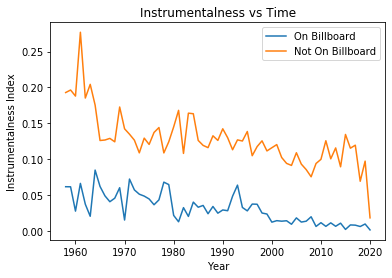

In [110]:
visualize_data_compare("instrumentalness")

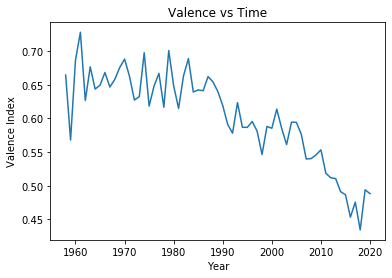

In [70]:
visualize_data("valence", bb_df)

In [ ]:
bb_df.plot(x ='year', y='loudness', kind = 'scatter')

In [30]:
y_rows

,id,name,artists,year,release_date,duration_ms,valence,acousticness,danceability,energy,...,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,on_billboard,year_on_billboard
117,5DX3P3b7kv8266XyuA7fsS,Angel Baby - 1998 Remaster,['Dean Martin'],1958,1958,166160,0.514,0.940,0.603,0.233,...,0.000000,6,0.1260,-12.300,1,31,0.0380,111.263,1,[]
125,5ZbmyXPF6h1JCCQiFQaTie,Little Red Riding Hood,['The Big Bopper'],1958,1958-01-01,132067,0.973,0.817,0.606,0.752,...,0.000009,0,0.0382,-5.758,0,29,0.0787,161.978,1,[]
188,0plxbPQf0Y4KQT0wFAFN95,Mr. Lucky,['Henry Mancini'],1958,1958,132333,0.190,0.775,0.352,0.378,...,0.797000,2,0.1310,-12.043,0,20,0.0313,121.897,1,[]
18658,5ZWuiWcMTBohMTTfdD5qys,Big Bopper's Wedding,['The Big Bopper'],1958,1958-01-01,132040,0.969,0.796,0.621,0.860,...,0.000000,10,0.0595,-5.977,1,26,0.0965,94.943,1,[]
18706,5J65xr8NkvpHy9RkxzSUAO,"Frankie's Man, Johnny",['Johnny Cash'],1958,1958-11,135360,0.933,0.643,0.741,0.754,...,0.000000,3,0.1240,-5.582,0,24,0.0653,160.140,1,[]
36494,6K6Ap90AcwpXarhxR5IK9V,It's Raining Outside,['The Platters'],1958,1958-01-01,171560,0.349,0.788,0.240,0.268,...,0.000053,3,0.2100,-15.201,1,25,0.0326,72.191,1,[]
36500,2jmOQZ16pdAC6t7GYTyFqS,Smooth Operator,['Sarah Vaughan'],1958,1958-07-07,140240,0.723,0.795,0.658,0.537,...,0.000009,3,0.1710,-10.575,1,22,0.0449,121.550,1,[]
36578,1xYZbzKH9rRC2x0tiOVgB7,Eternally,['Sarah Vaughan'],1958,1958-07-07,143493,0.160,0.955,0.238,0.282,...,0.001120,5,0.1010,-12.521,1,23,0.0327,133.375,1,[]
53824,677oYgkn4m90Zvq4lQH2B8,Saro Jane,['The Kingston Trio'],1958,1958-06-01,144267,0.831,0.440,0.548,0.421,...,0.000000,0,0.3630,-10.660,1,14,0.0362,144.778,1,[]
53839,1E5cZzKmVgLLJcLI6HPbn4,I'm Here To Get My Baby Out Of Jail,['The Everly Brothers'],1958,1958,217907,0.573,0.780,0.508,0.225,...,0.000000,3,0.0877,-15.402,1,13,0.0285,64.525,1,[]
